# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your https://jupyterhub.ischool.syr.edu/ workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.ml import feature, regression, Pipeline, pipeline
from pyspark.sql import types, Row, functions as fn
from pyspark import sql
import pandas as pd
import matplotlib.pyplot as plt

# Part 1: PCA and feature engineering

The government of Syracuse is trying to understand how to better keep its streets in good condition. Luckily, they have a datset obtained from patching said streets. Using this dataset, they want to easily visualize the characteristics of the city.

In [2]:
# load the data
syracuse_streets = spark.read.json("syracuse.json.gz")

In particular, the city is interested in understanding the following features:

- `Latitude` 
- `Longitude`
- `crack`: number of cracks on the street (visually inspected)
- `patch`: number of patches on the street (visually inspected)
- `pavement`: quality of the pavement
- `length`: street length
- `width`: street width

In [3]:
# take a look at the numerical features
syracuse_streets.select(['Latitude', 
               'Longitude', 
               'crack', 
               'patch',  
               'pavement',
               'length', 
               'width']).limit(10).toPandas()

,Latitude,Longitude,crack,patch,pavement,length,width
0,-76.152482,42.997837,3,4,3,1064,27
1,-76.152482,42.997837,4,5,3,1064,27
2,-76.152482,42.997837,4,4,3,1064,27
3,-76.152482,42.997837,3,4,3,1064,27
4,-76.152482,42.997837,4,2,3,1064,27
5,-76.152482,42.997837,4,5,3,1064,27
6,-76.152482,42.997837,4,4,3,1064,27
7,-76.152482,42.997837,4,4,3,1064,27
8,-76.152482,42.997837,3,2,3,1064,27
9,-76.159402,43.048630,4,5,6,650,34


For some of the questions, you will use the following user-defined function that transforms a vector into an array.

In [4]:
@fn.udf(returnType=types.ArrayType(types.FloatType()))
def to_array(col):
    return col.toArray().tolist()

For example, suppose you have latitude and longitude as a column of type vector. The way Spark encodes vectors is different from arrays and therefore they are not easy to manipulable. The above function allows you to transform a vector into an array for easy manipulation

In [5]:
(feature
 .VectorAssembler(inputCols=['Latitude', 'Longitude'], outputCol='feature_vector')
 .transform(syracuse_streets)
 .select('feature_vector')
 .show(5)
)

+--------------------+
|      feature_vector|
+--------------------+
|[-76.1524819382,4...|
|[-76.1524819382,4...|
|[-76.1524819382,4...|
|[-76.1524819382,4...|
|[-76.1524819382,4...|
+--------------------+
only showing top 5 rows



For example, we can take apart pieces of the array using `fn.expr('feature_array[i]')` notation to extract the ith element:

In [6]:
(feature
 .VectorAssembler(inputCols=['Latitude', 'Longitude'], outputCol='feature_vector')
 .transform(syracuse_streets)
 .select(to_array('feature_vector').alias('feature_array'))
 .select(fn.expr('feature_array[0]').alias('latitude'), 
         fn.expr('feature_array[1]').alias('longitude'))
 .show(5)
)

+---------+---------+
| latitude|longitude|
+---------+---------+
|-76.15248|42.997837|
|-76.15248|42.997837|
|-76.15248|42.997837|
|-76.15248|42.997837|
|-76.15248|42.997837|
+---------+---------+
only showing top 5 rows



You can do a lot more things with arrays. Take a look at https://sparkbyexamples.com/spark/spark-sql-array-functions/

## Question 1: (30 pts) Simple PCA

In this question, you will perform PCA to understand and visualize the data. You will analyze the features `Latitude`, `Longitude`, `crack`, `patch`,  `pavement`, `length`, and `width`.

In [7]:
feature_list = ['Latitude', 
               'Longitude', 
               'crack', 
               'patch',  
               'pavement',
               'length', 
               'width']

In the cell below, create a pipeline model (i.e., fitted pipeline) called `pca_2d` that takes the features above and projects them into **two** principal components. Before fitting the PCA model, make sure to **standardized** your data (i.e., center **and** divide by standard deviation) using `feature.StandardScaler`. Make sure the PCA part of the model generates an output column called `pc`.

In [8]:
# create pipeline to produce principal components of data
va = feature.VectorAssembler(inputCols=feature_list, outputCol='features') # Created VectorAssembler pipeline stage for converting features in feature_list to a single features vector
ss = feature.StandardScaler(withMean=True,inputCol="features", outputCol="scaledFeatures") # Created StandardScaler pipeline stage for standarizing the features vector, output as scaledFeatures
pca = feature.PCA(k=2, inputCol="scaledFeatures", outputCol="pc") # Projected scaledFeatures into two principal components using a PCA pipeline stage
pipe = Pipeline(stages=[va, ss, pca]) # Created pipeline estimator with va, ss, and pca stages
pca_2d = pipe.fit(syracuse_streets) # Fit pipeline to syracuse_streets dataset, assigned to pca_2d

Check that the fitted pipeline works:

In [9]:
pca_2d.transform(syracuse_streets).select(feature_list + ['pc']).show(5)

+--------------+-------------+-----+-----+--------+------+-----+--------------------+
|      Latitude|    Longitude|crack|patch|pavement|length|width|                  pc|
+--------------+-------------+-----+-----+--------+------+-----+--------------------+
|-76.1524819382|42.9978369009|    3|    4|       3|  1064|   27|[-1.7991028261303...|
|-76.1524819382|42.9978369009|    4|    5|       3|  1064|   27|[-1.5125989958525...|
|-76.1524819382|42.9978369009|    4|    4|       3|  1064|   27|[-1.6656924808867...|
|-76.1524819382|42.9978369009|    3|    4|       3|  1064|   27|[-1.7991028261303...|
|-76.1524819382|42.9978369009|    4|    2|       3|  1064|   27|[-1.9718794509550...|
+--------------+-------------+-----+-----+--------+------+-----+--------------------+
only showing top 5 rows



In [10]:
# 15 pts
assert type(pca_2d) == pipeline.PipelineModel
assert type(pca_2d.stages[-1]) == feature.PCAModel
assert set(pca_2d.stages[0].extractParamMap()[(pca_2d.stages[0].inputCols)]) == \
 {'Longitude', 'Latitude', 'crack', 'patch', 'pavement', 'length', 'width'}
assert feature.StandardScalerModel in list(map(type, pca_2d.stages))

Now, let's visualize the principal components. Create a Pandas dataframe that contains the `Longitude`, PC 1 (name it `pc1`), and PC 2 (name it `pc2`). You should use the udf `to_array` defined above to pluck the first and second component of the principal component into their own columns. Call this pandas dataframe `syracuse_2d`.

In [11]:
# put your code here to produce a pandas dataframe with columns Longitude, pc1, and pc2
syracuse_2d = pca_2d.transform(syracuse_streets).select(feature_list + ['pc']) # Returned transformed dataframe using pca_2d pipeline
syracuse_2d = syracuse_2d.select(fn.col('Longitude').alias('Longitude'), to_array('pc').alias('pc_array')) # Selected Longitude and PC columns with PC values as an array
syracuse_2d = syracuse_2d.select(fn.col('Longitude').alias('Longitude'), fn.expr('pc_array[0]').alias('pc1'), fn.expr('pc_array[1]').alias('pc2')) # Selected specific values within the pc_array, in addition to Longitude
syracuse_2d = syracuse_2d.toPandas() # Converted to a pandas dataframe

In [12]:
syracuse_2d

,Longitude,pc1,pc2
0,42.997837,-1.799103,0.122675
1,42.997837,-1.512599,-1.289295
2,42.997837,-1.665692,-0.645648
3,42.997837,-1.799103,0.122675
4,42.997837,-1.971879,0.641645
...,...,...,...
7821,43.004144,-1.612041,-0.301039
7822,43.004144,-1.898545,1.110930
7823,43.004144,-1.765135,0.342607
7824,43.004144,-1.612041,-0.301039


In [13]:
# 10 pts
assert set(syracuse_2d.columns) == {'Longitude', 'pc1', 'pc2'}
assert syracuse_2d.shape[0] == syracuse_streets.count()

The code below will plot the dataframe and color points by Longitude:

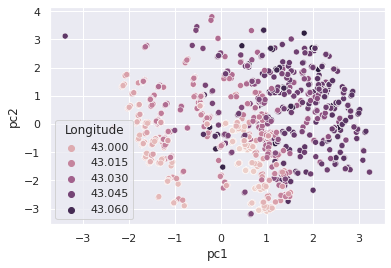

In [14]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.scatterplot(data=syracuse_2d, x='pc1', y='pc2', hue='Longitude');

**(5 pts)**: Given the plot above, do you think the *loading* on Longitude is bigger in principal component 1 or principal component 2? Elaborate.

Given the plot above, I think the loading on Longitude is bigger in principal component 1 than principal component 2 because the Longitude data points are skewed more in that direction. 

## Question 2: (20 pts) More PCA

In the previous section, we only limited our analysis to two principal components. However, it is unclear whether two dimensions capture enough of the data.

In the following question, fit a new PCA analysis model, similar to that of Question 1, where you include all principal components (seven principal components because length of `feature_list` is 7). Call this PCA pipeline `pca_all`. You can reuse some of the components of the pipeline above

In [15]:
# create pipeline to produce principal components of data
va = feature.VectorAssembler(inputCols=feature_list, outputCol='features') # Created VectorAssembler pipeline stage for converting features in feature_list to a single features vector
ss = feature.StandardScaler(withMean=True, inputCol="features", outputCol="scaledFeatures") # Created StandardScaler pipeline stage for standarizing the features vector, output as scaledFeatures
pca = feature.PCA(k=7, inputCol="scaledFeatures", outputCol="pc") # Projected scaledFeatures into seven principal components using a PCA pipeline stage
pipe = Pipeline(stages=[va, ss, pca]) # Created pipeline estimator with va, ss, and pca stages
pca_all = pipe.fit(syracuse_streets) # Fit pipeline to syracuse_streets dataset, assigned to pca_all

Test your pipeline below

In [16]:
pca_all.transform(syracuse_streets).select(to_array('pc')).show(5)

+--------------------+
|        to_array(pc)|
+--------------------+
|[-1.7991028, 0.12...|
|[-1.512599, -1.28...|
|[-1.6656924, -0.6...|
|[-1.7991028, 0.12...|
|[-1.9718795, 0.64...|
+--------------------+
only showing top 5 rows



In [17]:
# 5 pts
assert type(pca_all) == pipeline.PipelineModel
assert type(pca_all.stages[-1]) == feature.PCAModel

In class, we saw that by definition the first principal component will have the most variance, the second principal component will have the second most variance, and so on. Let's define $s_i^2$ as the variance of principal component $i$ (where $i$ goes from 1 to $p$ principal components). Let's define the cumulative variance as 
$$
c_i = \sum_{k=1}^{i} s_k^2
$$
and cumulative percent of total variance as
$$
p_i = \frac{c_i}{c_p}
$$

A genius of the highest caliber has defined the following quantity
$$
g_i = p_i (1-p_i)
$$

In the question below, you will be asked to find the optimal value $i$ such that $g_i$ is maximized. 

In Spark, you can access the percent of total variance for a component $i$
$$
\frac{s_i^2}{c_p}
$$

in a PCA fitted model with the attribute `explainedVariance`. (hint: you can access the fitted model using the `stages` attribute of the fitted pipeline).

Create a list or numpy array with each of the $g_i$ values and called it `gi` and store the optimal $g_i$ in `optimal_gi` variable. Also, store the values $p_i$ in a variable `pi`

In [18]:
# create gi and optimal_gi
variance = np.array(pca_all.stages[2].explainedVariance) # Created variance numpy array with the attribute explainedVariance from the pca stage of the pca_all pipeline
pi = np.cumsum(variance) # Returned cumulative sum numpy array for percent of total variance, assigned to pi
gi = [] # Created empty list for gi
for value in pi: # For value in pi
    gi.append(value*(1-value)) # Append value(1-value) to gi list
gi = np.array(gi) # Convert gi list to numpy array
optimal_i = np.argmax(gi, axis=0)+1 # Returned i for optimal gi
optimal_gi = gi.max() # Returned optimal gi
print(f'pi values: {pi}') # Printed pi array
print(f'gi values: {gi}') # Printed gi array
print(f'optimal_i: {optimal_i}, optimal_gi: {optimal_gi}') # Printed optimal i and optimal gi values

pi values: [0.29392242 0.5090816  0.69804576 0.80775073 0.88598753 0.95251323
 1.        ]
gi values: [0.20753203 0.24991752 0.21077788 0.15528949 0.10101363 0.04523178
 0.        ]
optimal_i: 2, optimal_gi: 0.24991752447577478


The cumulative percent of total variance should look like:

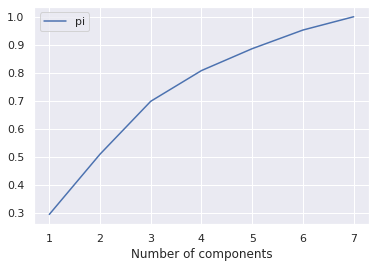

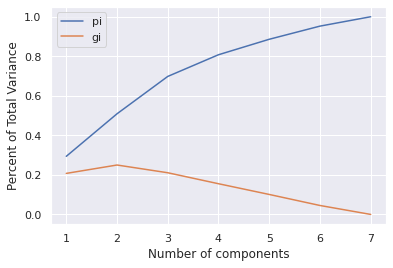

In [19]:
# Visualize both
plt.plot(range(1,8),pi);
plt.plot(range(1,8),gi);
plt.legend(['pi', 'gi']);
plt.xlabel('Number of components');
plt.ylabel('Percent of Total Variance');

In [20]:
# 15 pts
assert len(pi) == 7
assert len(gi) == 7
# pi should be cumulative
assert np.alltrue(np.diff(pi) >= 0)